# Understanding Travel Demand through Passively-generated Mobile Data: a Python-based Mobility Analysis Workshop
## C2SMARTER Student Learning Hub Series

### March 7th, 2025

## Ekin Uğurel
### Ph.D. Candidate, Department of Civil and Environmental Engineering, University of Washington
### [ekinugurel.github.io](https://ekinugurel.github.io)


In [ ]:
import pandas as pd
import os
#import wget

#### We will be utilizing open data created by the GeoDS Lab at UW-Madison: https://github.com/GeoDS/COVID19USFlows

In [ ]:
#data_folder="./mobilityflows"
#for i in range(20):
#    url = "https://raw.githubusercontent.com/GeoDS/COVID19USFlows-WeeklyFlows-Ct2021/master/weekly_flows/ct2ct/2021_01_04/weekly_ct2ct_2021_01_04_"+str(i)+".csv"
#    wget.download(url, out='./mobilityflows')

In [9]:
# Merge all files
data_folder="./mobilityflows"
flow_all = []
for file in os.listdir(data_folder):
    if file[-3:] == "csv" and 'weekly_ct2ct' in file:
        #print(data_folder+"/"+file)
        flow_df = pd.read_csv(data_folder+"/"+file)
        flow_all.append(flow_df)
flow_all = pd.concat([x for x in flow_all])
print(flow_all.shape)
flow_all.head()

(6883602, 9)


,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date_range,visitor_flows,pop_flows
0,25009202102,25025010300,-70.918836,42.481209,-71.101826,42.339422,01/04/21 - 01/10/21,4,118.0
1,25009202102,25009202101,-70.918836,42.481209,-70.906781,42.475565,01/04/21 - 01/10/21,114,3368.0
2,25009202102,25009206800,-70.918836,42.481209,-70.943685,42.466524,01/04/21 - 01/10/21,16,472.0
3,25009202102,25009205500,-70.918836,42.481209,-70.960897,42.474901,01/04/21 - 01/10/21,4,118.0
4,25009202102,25009206100,-70.918836,42.481209,-70.954724,42.465693,01/04/21 - 01/10/21,9,265.0


In [10]:
print(flow_all.dtypes)

geoid_o            int64
geoid_d            int64
lng_o            float64
lat_o            float64
lng_d            float64
lat_d            float64
date_range        object
visitor_flows      int64
pop_flows        float64
dtype: object


In [11]:
# Isolate New York county (36061)
ny_county_flows_ct = flow_all[(flow_all['geoid_o'] > 36060999999) & (flow_all['geoid_o'] < 36061999999) & (flow_all['geoid_d'] < 36061999999) & (flow_all['geoid_d'] > 36060999999)]
print(ny_county_flows_ct.shape)
ny_county_flows_ct.head()

(10432, 9)


,geoid_o,geoid_d,lng_o,lat_o,lng_d,lat_d,date_range,visitor_flows,pop_flows
55044,36061005400,36061010400,-73.993678,40.738811,-73.977673,40.760779,01/04/21 - 01/10/21,4,272.0
55046,36061005400,36061009300,-73.993678,40.738811,-74.000875,40.747112,01/04/21 - 01/10/21,4,272.0
55049,36061005400,36061005800,-73.993678,40.738811,-73.990517,40.743150,01/04/21 - 01/10/21,4,272.0
55050,36061005400,36061007100,-73.993678,40.738811,-73.999914,40.735448,01/04/21 - 01/10/21,8,544.0
55051,36061005400,36061000800,-73.993678,40.738811,-73.993791,40.709799,01/04/21 - 01/10/21,4,272.0


## Delete Larger Data from Memory
Due to memory limitations within Binder (hosted with Kubernetes), we will delete the larger data from memory.

In [12]:
del flow_all, flow_df, file

In [ ]:
import censusdata
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import folium
import skmob

In [ ]:
ny_county_flows_ct[[ 'geoid_o', 'geoid_d']] = ny_county_flows_ct[['geoid_o','geoid_d']].astype(str) # Multiple columns string conversion
print(ny_county_flows_ct.dtypes)

## Download the Census data for New York county
Here we will leverage the 'censusdata' package, which is a Python wrapper for the US Census Bureau API. We will download the Census data for New York county.

Below are some helper functions to download the data. Thanks to Eric Gagliano and Professor David Shean for developing and sharing these functions.

In [6]:
def get_census_data(tables, state, county, year=2022):

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2022 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*'), ('block group', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    return data

def get_census_tract_geom(state_fips, county_fips):

    # find state and county fips here: https://www.census.gov/geographies/reference-files/2017/demo/popest/2017-fips.html
    
    # Download the census tract shapefiles
    tracts = gpd.read_file(f'https://www2.census.gov/geo/tiger/TIGER2021/TRACT/tl_2021_{state_fips}_tract.zip')

    # set index as tract
    tracts = tracts.rename(columns={'TRACTCE':'Tract'}).set_index('Tract')

    # Filter to only King County
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts[['geometry']]

    return tracts

def convert_to_percentages(df, total_population_column='TotalPopulation'):
    for column in df.columns:
        if column.startswith('Population'):
            new_column_name = 'Percent' + column
            df[new_column_name] = (df[column] / df[total_population_column]) * 100
            df.drop(column, axis=1, inplace=True)
    return df

In [7]:
# Define the state and county for New York City
state_fips = '36'  # FIPS code for New York
county_fips = '061'  # FIPS code for Brooklyn

tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B01002_001E': 'MedianAge',
'B02001_002E': 'PopulationWhiteAlone',
'B02001_003E': 'PopulationBlackAlone',
'B02001_004E': 'PopulationAmericanIndianAlaskaNativeAlone',
'B02001_005E': 'PopulationAsianAlone',
'B02001_006E': 'PopulationNativeHawaiianPacificIslanderAlone',
'B02001_007E': 'PopulationSomeOtherRaceAlone',
'B02001_008E': 'PopulationTwoOrMoreRaces',
'B03002_003E': 'PopulationNotHispanicWhiteAlone',
'B03003_003E': 'PopulationHispanic',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
'B08303_002E': 'TravelTimeToWork_lessthan5min',
'B08303_003E': 'TravelTimeToWork_5to9min',
'B08303_004E': 'TravelTimeToWork_10to14min',
'B08303_005E': 'TravelTimeToWork_15to19min',
'B08303_006E': 'TravelTimeToWork_20to24min',
'B08303_007E': 'TravelTimeToWork_25to29min',
'B08303_008E': 'TravelTimeToWork_30to34min',
'B08303_009E': 'TravelTimeToWork_35to44min',
'B08303_010E': 'TravelTimeToWork_45to59min',
'B08303_011E': 'TravelTimeToWork_60to89min',
'B08303_012E': 'TravelTimeToWork_90ormoremin',
'B08301_002E': 'MeansOfTransportationToWork_CarTruckVan',
'B08301_010E': 'MeansOfTransportationToWork_PublicTransportation',
'B08301_018E': 'MeansOfTransportationToWork_Bicycle',
'B08301_019E': 'MeansOfTransportationToWork_Walked',
'B08301_021E': 'MeansOfTransportationToWork_WorkedFromHome',
}

In [8]:
# Download the data
data = censusdata.download('acs5', 2021,  # Use 2021 ACS 5-year estimates
                            censusdata.censusgeo([('state', state_fips), ('county', county_fips), ('tract', '*'), ('block group', '*')]),
                            list(tables.keys()))

census_data = get_census_data(tables, state_fips, county_fips)
census_data.head()

,Name,MedianIncome,TotalPopulation,MedianAge,PopulationWhiteAlone,PopulationBlackAlone,PopulationAmericanIndianAlaskaNativeAlone,PopulationAsianAlone,PopulationNativeHawaiianPacificIslanderAlone,PopulationSomeOtherRaceAlone,...,TravelTimeToWork_30to34min,TravelTimeToWork_35to44min,TravelTimeToWork_45to59min,TravelTimeToWork_60to89min,TravelTimeToWork_90ormoremin,MeansOfTransportationToWork_CarTruckVan,MeansOfTransportationToWork_PublicTransportation,MeansOfTransportationToWork_Bicycle,MeansOfTransportationToWork_Walked,MeansOfTransportationToWork_WorkedFromHome
Tract,,,,,,,,,,,,,,,,,,,,,
000100,Block Group 1; Census Tract 1; New York County...,-666666666,0,-666666666.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000201,Block Group 0; Census Tract 2.01; New York Cou...,-666666666,0,-666666666.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000201,Block Group 1; Census Tract 2.01; New York Cou...,64665,817,38.5,342,31,0,259,0,62,...,34,60,49,52,0,5,153,15,139,97
000201,Block Group 2; Census Tract 2.01; New York Cou...,19208,1849,14.2,77,226,0,154,0,214,...,73,5,101,17,2,38,200,7,43,49
000202,Block Group 0; Census Tract 2.02; New York Cou...,-666666666,0,-666666666.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips).to_crs('EPSG:4326')
tract_geom_gdf.head()

,geometry
Tract,
012700,"POLYGON ((-73.99316 40.76281, -73.99270 40.763..."
012800,"POLYGON ((-73.96432 40.77042, -73.96382 40.771..."
013000,"POLYGON ((-73.96753 40.77178, -73.96704 40.772..."
013300,"POLYGON ((-73.99133 40.76531, -73.99088 40.765..."
013400,"POLYGON ((-73.95918 40.77170, -73.95872 40.772..."


In [21]:
# format census data, change dtype of Tract so that it matches census_data
census_data = census_data.reset_index()
census_data['Tract'] = census_data['Tract'].astype('object')

census_data_geoms = census_data.merge(tract_geom_gdf, on='Tract', how='left')
census_data_geoms[['Tract', 'Name', 'geometry']].head()

,Tract,Name,geometry
0,000100,Block Group 1; Census Tract 1; New York County...,"MULTIPOLYGON (((-74.04075 40.70017, -74.04073 ..."
1,000201,Block Group 0; Census Tract 2.01; New York Cou...,"POLYGON ((-73.98716 40.71431, -73.98608 40.714..."
2,000201,Block Group 1; Census Tract 2.01; New York Cou...,"POLYGON ((-73.98716 40.71431, -73.98608 40.714..."
3,000201,Block Group 2; Census Tract 2.01; New York Cou...,"POLYGON ((-73.98716 40.71431, -73.98608 40.714..."
4,000202,Block Group 0; Census Tract 2.02; New York Cou...,"POLYGON ((-73.98534 40.71446, -73.98471 40.714..."


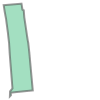

In [25]:
census_data_geoms['geometry'].iloc[1]

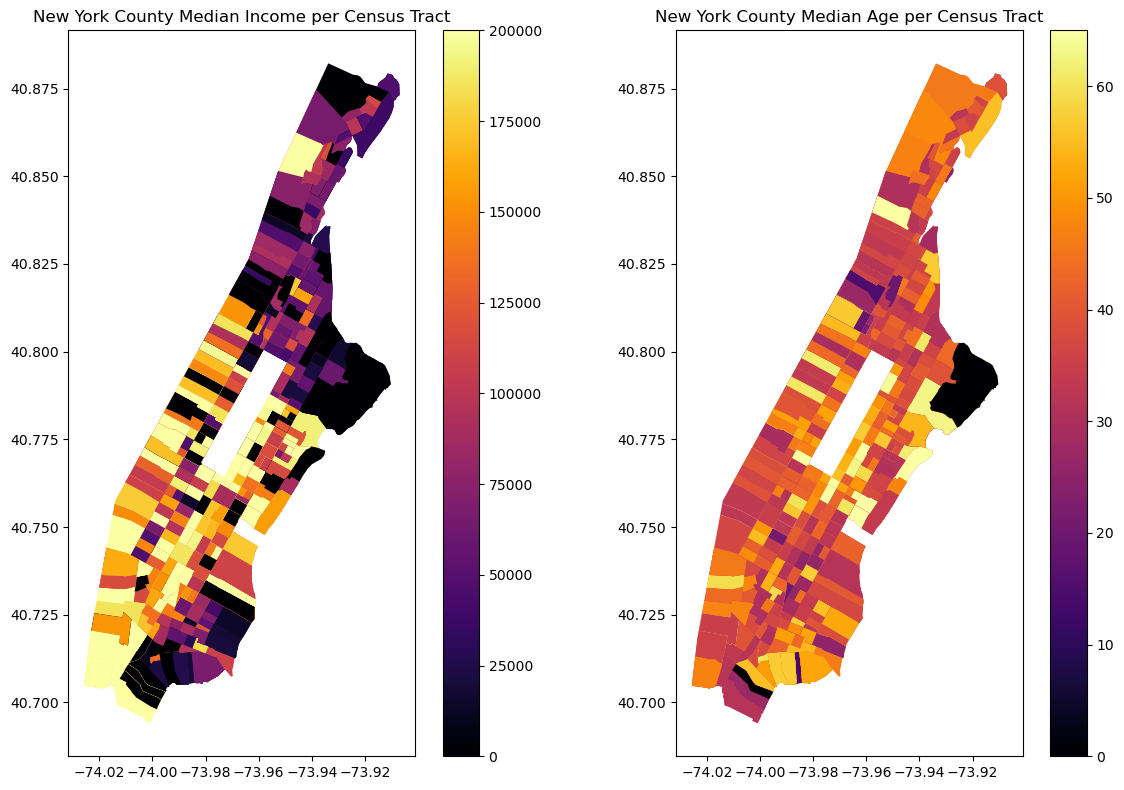

In [26]:
# Convert to geodataframe
census_data_geoms_gdf = gpd.GeoDataFrame(census_data_geoms, crs='EPSG:4326', geometry=census_data_geoms.geometry)

# Remove tracts with no population
census_data_geoms_gdf = census_data_geoms_gdf[census_data_geoms_gdf.TotalPopulation > 0]

# Plot the data
f, ax = plt.subplots(1,2,figsize=(12,8))
# New York County Median Income
king_plot = census_data_geoms_gdf.plot(column='MedianIncome', cmap='inferno', legend=True, ax=ax[0], vmax=200000, vmin=0)
ax[0].set_title("New York County Median Income per Census Tract")

# New York County Median Age
census_data_geoms_gdf.plot(column='MedianAge', cmap='inferno', legend=True, ax=ax[1], vmin=0, vmax=65)
ax[1].set_title("New York County Median Age per Census Tract")

plt.tight_layout()

In [27]:
census_data_geoms_gdf['GEOID'] = '36061' + census_data_geoms_gdf['Tract']
census_data_geoms_gdf['GEOID'] = census_data_geoms_gdf['GEOID'].astype(str)

In [ ]:
# Save as CSV in case the federal government shuts down...
#census_data_geoms_gdf.to_csv('NY_census_data_geoms_gdf.csv', index=False)

## Merging Census data with the OD data
We will use 'pd.DataFrame.merge' to merge the Census data with the OD data. You can read about how to use this function more generally here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

In this case, we will do a 'right' merge on the GEOID column. This is equivalent to a SQL right outer join, using only keys from the right DataFrame (census_data_geoms_gdf). We do this to keep all the rows from the census data, even if there is no corresponding row in the OD data.

In [28]:
ny_merged_o = ny_county_flows_ct.merge(census_data_geoms_gdf, left_on='geoid_o', right_on='GEOID', how='right')

In [29]:
# Let's confirm what we are doing is working as intended. Let's look at the number of unique GEOIDs in each dataset.
print(f"Unique origin GEOIDs in NY County Flows: {ny_county_flows_ct['geoid_o'].nunique()}")
print(f"Unique destination GEOIDs in NY County Flows: {ny_county_flows_ct['geoid_d'].nunique()}")
print(f"Unique GEOIDs in NY County Census Data: {census_data_geoms_gdf['GEOID'].nunique()}")
print(f"Unique GEOIDs in Merged Data: {ny_merged_o['GEOID'].nunique()}")

Unique origin GEOIDs in NY County Flows: 287
Unique destination GEOIDs in NY County Flows: 287
Unique GEOIDs in NY County Census Data: 304
Unique GEOIDs in Merged Data: 304


Let's now merge again to get the destination census data in the same tabular format.

In [30]:
# Let's merge again to now get the destination census data
ny_merged_od = ny_merged_o.merge(census_data_geoms_gdf, left_on='geoid_d', right_on='GEOID', how='right', suffixes=('_origin', '_destination'))

In [31]:
# Check if ny_merged has any NA values
print(ny_merged_od.isna().sum())

geoid_o                                                   114
geoid_d                                                   114
lng_o                                                     114
lat_o                                                     114
lng_d                                                     114
                                                         ... 
MeansOfTransportationToWork_Bicycle_destination             0
MeansOfTransportationToWork_Walked_destination              0
MeansOfTransportationToWork_WorkedFromHome_destination      0
geometry_destination                                        0
GEOID_destination                                           0
Length: 91, dtype: int64


In [32]:
# Drop rows with NA values
ny_merged = ny_merged_od.dropna()

## Origin-Destination Matrix
To create this matrix, we can use the '.pivot_table()' method in pandas. This method is used to create a spreadsheet-style pivot table as a DataFrame. You can read more about this method here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

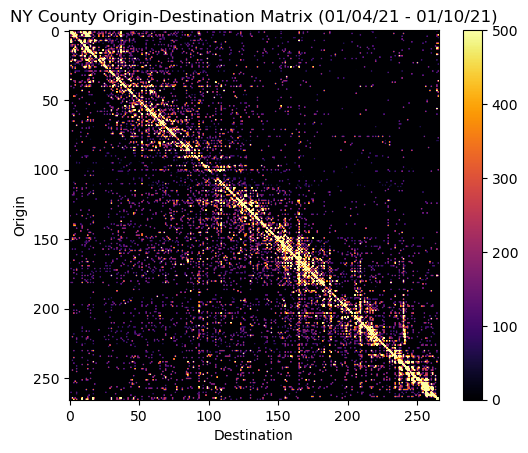

In [33]:
# Rename 'geoid_o' to 'origin' and 'geoid_d' to 'destination'
ny_merged = ny_merged.rename(columns={'geoid_o': 'origin', 'geoid_d': 'destination'})
ny_merged['flow'] = ny_merged['pop_flows']
ny_merged['tile_ID'] = ny_merged['origin']

# Convert ny_merged into a Origin-Destination matrix using pivot_table
od_matrix = ny_merged.pivot_table(index='origin', columns='destination', values='flow', fill_value=0)

# Plot the Origin-Destination matrix
plt.imshow(od_matrix, cmap='inferno', vmin=0, vmax=500)
plt.colorbar()
plt.title('NY County Origin-Destination Matrix (01/04/21 - 01/10/21)')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

Census tract map of New York county: https://www2.census.gov/geo/maps/DC2020/PL20/st36_ny/censustract_maps/c36061_new_york/DC20CT_C36061.pdf

In [35]:
ny_merged['flow'] = ny_merged['pop_flows']
ny_merged['tile_ID'] = ny_merged['origin']

# In NYMerged, convert origin, destination, and tile_ID to int64
ny_merged['origin'] = ny_merged['origin'].astype(int)
ny_merged['destination'] = ny_merged['destination'].astype(int)
ny_merged['tile_ID'] = ny_merged['tile_ID'].astype(int)

census_data_geoms_gdf['GEOID'] = census_data_geoms_gdf['GEOID'].astype(int)

# Check if all entries in 'origin' can be found in census_data_gdf['GEOID']
dest = set(ny_merged['destination']).difference(set(census_data_geoms_gdf['GEOID']))

# Drop all rows in ny_merged where destination is in dest
ny_merged = ny_merged[~ny_merged['destination'].isin(dest)]

#fdf = skmob.FlowDataFrame(ny_merged, 
#                          tessellation=census_data_geoms_gdf,
#                          tile_id = 'GEOID',
#)

In [ ]:
type(ny_merged)

In [ ]:
# load a spatial tessellation
url_tess = skmob.utils.constants.NY_COUNTIES_2011
tessellation = gpd.read_file(url_tess).rename(columns={'tile_id': 'tile_ID'})

# load real flows into a FlowDataFrame
fdf_ny_state = skmob.FlowDataFrame.from_file(skmob.utils.constants.NY_FLOWS_2011,
				tessellation=tessellation,
				tile_id='tile_ID',
				sep=",")


In [ ]:
fdf_ny_state.plot_flows(tiles='openstreetmap')

In [ ]:
# compute the total outflows from each location of the tessellation (excluding self loops)
tot_outflows = fdf[fdf['origin'] != fdf['destination']].groupby(by='origin', axis=0)[['flow']].sum().fillna(0)
tessellation = tessellation.merge(tot_outflows, left_on='tile_ID', right_on='origin').rename(columns={'flow': 'tot_outflow'})

In [ ]:
from skmob.models.gravity import Gravity

# instantiate a singly constrained Gravity model
gravity_singly = Gravity(gravity_type='singly cons/tetrained')
print(gravity_singly)

In [ ]:
# start the generation of the synthetic flows
np.random.seed(0)
synth_fdf = gravity_singly.generate(tessellation,
				   tile_id_column='tile_ID',
				   tot_outflows_column='tot_outflow',
				   relevance_column= 'population',
				   out_format='flows')
# print a portion of the synthetic flows
print(synth_fdf.head())

In [ ]:
# Calculate straight-line distance between origin and destination
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points in kilometers using the Haversine formula"""
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Calculate distances (using lat_o, lng_o, lat_d, lng_d from ny_merged_od)
ny_merged['distance_km'] = haversine_distance(
    ny_merged['lat_o'], ny_merged['lng_o'],
    ny_merged['lat_d'], ny_merged['lng_d']
)

# Drop rows where distance is zero
ny_merged = ny_merged[ny_merged['distance_km'] > 0]

# Create a log-scaled flow value (useful for visualization)
ny_merged['log_flow'] = np.log1p(ny_merged['flow'])  # log(1+x) to handle zero flows

## Exploring the Gravity Model Assumptions
### The gravity model assumes that flow is proportional to masses (populations) and inversely proportional to distance
$$
T_{ij} = K \cdot \frac{m_i^{\alpha} m_j^{\beta}}{d_{ij}^{\gamma}}
$$
where $T_{ij}$ is the flow from origin $i$ to destination $j$, $m_i$ and $m_j$ are the populations of the origin and destination, $d_{ij}$ is the distance between the origin and destination, and $K$, $\alpha$, $\beta$, and $\gamma$ are parameters to be estimated.

__Key Assumptions__:
1. Mass Attraction: The number of trips between two locations is proportional to the product of their populations.
2. Distance Decay: The number of trips between two locations is inversely proportional to the distance between them.
3. Independence: The number of trips between two locations is independent of the presence of other locations.

In [ ]:
# Let's calculate the gravity model term
ny_merged['gravity_term'] = (ny_merged['TotalPopulation_origin'] * ny_merged['TotalPopulation_destination']) / (ny_merged['distance_km']**2)
ny_merged['log_gravity_term'] = np.log1p(ny_merged['gravity_term'])
ny_merged['TotalPopulation'] = ny_merged['TotalPopulation_origin'] + ny_merged['TotalPopulation_destination']

# Visualize the relationship between flow and gravity model prediction
plt.figure(figsize=(12, 10))

# Plot 1: Flow vs. Distance
plt.subplot(2, 2, 1)
plt.scatter(ny_merged['distance_km'], ny_merged['flow'], alpha=0.4, s=10)
# Fit a linear regression line
m, b = np.polyfit(ny_merged['distance_km'], ny_merged['flow'], 1)
plt.plot(ny_merged['distance_km'], m * ny_merged['distance_km'] + b, color='red')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Distance (km)')
plt.ylabel('Flow Volume')
plt.title('Flow vs. Distance')
plt.grid(True, alpha=0.3)

# Plot 2: Flow vs. Origin Population
plt.subplot(2, 2, 2)
plt.scatter(ny_merged['TotalPopulation_origin'], ny_merged['flow'], alpha=0.4, s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Origin Population')
plt.ylabel('Flow Volume')
plt.title('Flow vs. Origin Population')
plt.grid(True, alpha=0.3)

# Plot 3: Flow vs. Destination Population
plt.subplot(2, 2, 3)
plt.scatter(ny_merged['TotalPopulation_destination'], ny_merged['flow'], alpha=0.4, s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Destination Population')
plt.ylabel('Flow Volume')
plt.title('Flow vs. Destination Population')
plt.grid(True, alpha=0.3)

# Plot 4: Flow vs. Gravity Model Term
plt.subplot(2, 2, 4)
plt.scatter(ny_merged['gravity_term'], ny_merged['flow'], alpha=0.4, s=10)
m, b = np.polyfit(ny_merged['gravity_term'], ny_merged['flow'], 1)
plt.plot(ny_merged['gravity_term'], m * ny_merged['gravity_term'] + b, color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Gravity Model Term (Pop_o * Pop_d / Distance²)')
plt.ylabel('Flow Volume')
plt.title('Flow vs. Gravity Model Prediction')
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('gravity_model_relationships.png', dpi=300)
plt.show()

# Calculate Pearson correlation between flow and gravity model term
flow_gravity_corr, p_value = pearsonr(ny_merged['log_flow'], ny_merged['log_gravity_term'])
print(f"Correlation between log(flow) and log(gravity term): {flow_gravity_corr:.4f}, p-value: {p_value:.4e}")


In [ ]:
from scipy.optimize import minimize
from scipy.special import factorial

# Define the gravity model function for MLE fitting
def gravity_model(params, pop_origin, pop_dest, distance):
    """
    Gravity model function for parameter estimation
    
    Parameters:
    -----------
    params : tuple
        (K, alpha, beta, gamma) - model parameters
    pop_origin : array-like
        Population at origin
    pop_dest : array-like
        Population at destination
    distance : array-like
        Distance between origin and destination
    
    Returns:
    --------
    array-like
        Predicted flows
    """
    K, alpha, beta, gamma = params
    return K * (pop_origin**alpha) * (pop_dest**beta) * (distance**(-gamma))

# Log-likelihood function for Poisson model (appropriate for count data like flows)
def neg_log_likelihood(params, pop_origin, pop_dest, distance, observed_flows):
    """
    Negative log-likelihood function for Poisson model
    
    Parameters:
    -----------
    params : tuple
        (K, alpha, beta, gamma) - model parameters
    pop_origin : array-like
        Population at origin
    pop_dest : array-like
        Population at destination
    distance : array-like
        Distance between origin and destination
    observed_flows : array-like
        Observed flows
    
    Returns:
    --------
    float
        Negative log-likelihood
    """
    predicted = gravity_model(params, pop_origin, pop_dest, distance)
    # Set a minimum value to avoid log(0)
    predicted = np.maximum(predicted, 1e-10)
    
    # Poisson log-likelihood (negative because we're minimizing)
    log_likelihood = np.sum(observed_flows * np.log(predicted) - predicted - np.log(factorial(observed_flows)))
    return -log_likelihood

def fit_gravity_model_mle(data_df):
    """
    Fit gravity model using Maximum Likelihood Estimation
    
    Parameters:
    -----------
    data_df : DataFrame
        DataFrame with columns for flows, population at origin and destination, and distance
    
    Returns:
    --------
    tuple
        (params, model_stats)
    """
    # Extract data
    flows = data_df['flow'].values
    pop_origin = data_df['TotalPopulation_origin'].values
    pop_dest = data_df['TotalPopulation_destination'].values
    distance = data_df['distance_km'].values
    
    # Ensure minimum distance (avoid division by zero)
    distance = np.maximum(distance, 0.1)
    
    # Initial parameter values
    initial_params = [0.01, 1.0, 1.0, 2.0]  # K, alpha, beta, gamma
    
    # Apply bounds to parameters (all must be positive except gamma)
    bounds = [(1e-10, None), (0, None), (0, None), (0, None)]
    
    # Fit using Maximum Likelihood Estimation
    result = minimize(
        neg_log_likelihood,
        initial_params,
        args=(pop_origin, pop_dest, distance, flows),
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    K, alpha, beta, gamma = result.x
    
    # Calculate fitted values
    fitted_flows = gravity_model(result.x, pop_origin, pop_dest, distance)
    
    # Calculate goodness-of-fit metrics
    correlation = np.corrcoef(flows, fitted_flows)[0, 1]
    
    # Calculate R-squared
    mean_flow = np.mean(flows)
    ss_total = np.sum((flows - mean_flow)**2)
    ss_residual = np.sum((flows - fitted_flows)**2)
    r_squared = 1 - (ss_residual / ss_total)
    
    # Create a dictionary with model statistics
    model_stats = {
        'K': K,
        'alpha': alpha,
        'beta': beta,
        'gamma': gamma,
        'correlation': correlation,
        'r_squared': r_squared,
        'success': result.success,
        'message': result.message
    }
    
    return result.x, model_stats


# Extract data
K, alpha, beta, gamma = fit_gravity_model_mle(ny_merged)[0]

# Calculate predicted flows
ny_merged['predicted_gravity'] = gravity_model((K, alpha, beta, gamma), 
                                               ny_merged['TotalPopulation_origin'], 
                                               ny_merged['TotalPopulation_destination'], 
                                               ny_merged['distance_km']
                                               )
    
# Visualize results
plt.figure(figsize=(12, 10))

# Plot 1: Observed vs Predicted (linear scale)
plt.subplot(2, 2, 1)
plt.scatter(ny_merged['flow'], ny_merged['predicted_gravity'], alpha=0.4, s=10)
plt.plot([0, ny_merged['flow'].max()], [0, ny_merged['flow'].max()], 'r--', alpha=0.7)
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow (Gravity Model)')
plt.title('Observed vs. Predicted Flows (Linear Scale)')
plt.grid(True, alpha=0.3)

# Plot 2: Observed vs Predicted (log scale)
plt.subplot(2, 2, 2)
plt.scatter(ny_merged['flow'], ny_merged['predicted_gravity'], alpha=0.4, s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed Flow (log scale)')
plt.ylabel('Predicted Flow (log scale)')
plt.title('Observed vs. Predicted Flows (Log Scale)')
plt.grid(True, alpha=0.3)

# Plot 3: Residuals vs. Predicted
plt.subplot(2, 2, 3)
residuals = ny_merged['flow'] - ny_merged['predicted_gravity']
plt.scatter(ny_merged['predicted_gravity'], residuals, alpha=0.4, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Flow')
plt.ylabel('Residuals (Observed - Predicted)')
plt.title('Residuals vs. Predicted Values')
plt.grid(True, alpha=0.3)

# Plot 4: Residuals vs. Distance
plt.subplot(2, 2, 4)
plt.scatter(ny_merged['distance_km'], residuals, alpha=0.4, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('Distance (km, log scale)')
plt.ylabel('Residuals (Observed - Predicted)')
plt.title('Residuals vs. Distance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('gravity_model_fit.png', dpi=300)
plt.show()

# Summary of gravity model parameters
print(f"Gravity Model Parameters:")
print(f"K = {K:.6f}")
print(f"α (origin population effect) = {alpha:.4f}")
print(f"β (destination population effect) = {beta:.4f}")
print(f"γ (distance decay) = {gamma:.4f}")


## Income-based Mobility Patterns Analysis
### Let's calculate median income categories for quantiles

In [ ]:
income_bins = pd.qcut(ny_merged['MedianIncome_origin'], 5, labels=False)  # Split into quintiles
ny_merged['income_quintile'] = income_bins + 1  # Make 1-based

# Do the same for destination income
dest_income_bins = pd.qcut(ny_merged['MedianIncome_destination'], 5, labels=False)
ny_merged['dest_income_quintile'] = dest_income_bins + 1

# Create income group descriptions for better readability
income_labels = {
    1: 'Very Low Income',
    2: 'Low Income',
    3: 'Middle Income',
    4: 'High Income',
    5: 'Very High Income'
}

# Analyze flow patterns by income groups
income_flow_matrix = ny_merged.pivot_table(
    values='flow',
    index='income_quintile',
    columns='dest_income_quintile',
    aggfunc='sum',
    fill_value=0
)

# Create a normalized version (by row)
income_flow_matrix_norm = income_flow_matrix.div(income_flow_matrix.sum(axis=1), axis=0)

In [ ]:
# Visualize income-based flow matrix
plt.figure(figsize=(14, 12))

# Plot the raw flow matrix
plt.subplot(2, 1, 1)
sns.heatmap(income_flow_matrix, annot=True, fmt='.0f', cmap='viridis',
            xticklabels=[income_labels[i] for i in range(1, 6)],
            yticklabels=[income_labels[i] for i in range(1, 6)])
plt.xlabel('Destination Income Group')
plt.ylabel('Origin Income Group')
plt.title('Total Flow Volume Between Income Groups')

# Plot the normalized flow matrix
plt.subplot(2, 1, 2)
sns.heatmap(income_flow_matrix_norm, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=[income_labels[i] for i in range(1, 6)],
            yticklabels=[income_labels[i] for i in range(1, 6)])
plt.xlabel('Destination Income Group')
plt.ylabel('Origin Income Group')
plt.title('Normalized Flow Between Income Groups (row percentages)')

plt.tight_layout()
plt.savefig('income_based_flows.png', dpi=300)
plt.show()

## Spatial Visualization of Flows
### We can create interactive maps using the 'folium' package. You can read more about this package here: https://python-visualization.github.io/folium/

In [ ]:
def visualize_flows_on_map(gdf, flows_df, max_flows=1000, min_flow=5, save_path=None):
    """
    Visualize flows on an interactive map
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        Geodataframe with census tracts
    flows_df : DataFrame
        DataFrame with flow data (must have origin, destination, flow, lng_o, lat_o, lng_d, lat_d)
    max_flows : int
        Maximum number of flows to visualize
    min_flow : float
        Minimum flow value to visualize
    save_path : str, optional
        Path to save the interactive map HTML file
    """
    # Filter flows to reduce visual clutter
    filtered_flows = flows_df[flows_df['flow'] > min_flow].sort_values('flow', ascending=False).head(max_flows)
    
    # Create map centered on the mean coordinates
    center_lat = flows_df[['lat_o', 'lat_d']].values.mean()
    center_lng = flows_df[['lng_o', 'lng_d']].values.mean()
    
    m = folium.Map(location=[center_lat, center_lng], zoom_start=12, tiles='cartodbpositron')
    
    # Add census tracts
    folium.GeoJson(
        gdf,
        style_function=lambda x: {
            'fillColor': 'transparent',
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.1,
        }
    ).add_to(m)
    
    # Normalize flow values for line width
    max_flow = filtered_flows['flow'].max()
    min_flow = filtered_flows['flow'].min()
    
    # Add flow lines
    for _, row in filtered_flows.iterrows():
        # Calculate line width based on flow
        width = 1 + 5 * ((row['flow'] - min_flow) / (max_flow - min_flow))
        
        # Determine color based on distance (shorter = more blue, longer = more red)
        norm_distance = min(1.0, row['distance_km'] / 10)  # Normalize to 0-1 range (capped at 10km)
        color = f'#{int(255 * norm_distance):02x}{0:02x}{int(255 * (1-norm_distance)):02x}'
        
        # Draw the flow line
        folium.PolyLine(
            locations=[[row['lat_o'], row['lng_o']], [row['lat_d'], row['lng_d']]],
            color=color,
            weight=width,
            opacity=0.7
        ).add_to(m)
    
    # Save map if path is provided
    if save_path:
        m.save(save_path)
        
    return m

flow_map = visualize_flows_on_map(
    census_data_geoms_gdf,
    ny_merged,
    max_flows=50000,
    min_flow=1000,
    save_path=None
)

In [ ]:
flow_map

## Analyzing Transportation Preferences by Income
### Let's calculate percent of each transportation mode

In [ ]:
transport_columns = [
    'MeansOfTransportationToWork_CarTruckVan_origin',
    'MeansOfTransportationToWork_PublicTransportation_origin',
    'MeansOfTransportationToWork_Bicycle_origin',
    'MeansOfTransportationToWork_Walked_origin',
    'MeansOfTransportationToWork_WorkedFromHome_origin'
]

# Group by income quintile and calculate mean for each transportation mode
transport_by_income = ny_merged.groupby('income_quintile')[transport_columns].mean()

# Calculate total commuters for each row
transport_by_income['total_commuters'] = transport_by_income.sum(axis=1)

# Convert to percentages
for col in transport_columns:
    transport_by_income[f'{col}_pct'] = transport_by_income[col] / transport_by_income['total_commuters'] * 100

In [ ]:
plt.figure(figsize=(20, 12))

# Create stacked bar chart of transportation modes by income
transport_pct_columns = [f'{col}_pct' for col in transport_columns]
ax = transport_by_income[transport_pct_columns].plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    figsize=(14, 8)
)

legend = ['Car/Truck/Van', 'Public Transportation', 'Bicycle', 'Walked', 'Worked from Home']

plt.xlabel('Income Quintile',  fontsize=20)
plt.ylabel('Percentage of Commuters',  fontsize=20)
#plt.title('Means of Transportation by Income Group')
plt.xticks(range(5), [income_labels[i] for i in range(1, 6)], rotation=30)
plt.legend(legend, loc='upper center', bbox_to_anchor=(1.2, 1), fontsize=16)
plt.grid(False)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
#plt.savefig('transportation_by_income.png', dpi=300)
plt.show()

## Flow Distance Analysis by Income Group
### Let's calculate the average travel distance by income group

In [ ]:

distance_by_income = ny_merged.groupby('income_quintile')['distance_km'].agg(['mean', 'median', 'count'])
distance_by_income.columns = ['Mean Distance (km)', 'Median Distance (km)', 'Number of Flows']

print("Travel Distance by Income Group:")
print(distance_by_income)

# Visualize travel distance distribution by income
plt.figure(figsize=(14, 8))
sns.boxplot(x='income_quintile', y='distance_km', data=ny_merged, palette='viridis')
plt.xlabel('Income Quintile',  fontsize=20)
plt.ylabel('Travel Distance (km)', fontsize=20)
#plt.title('Distribution of Travel Distances by Income Group', fontsize=20)
plt.xticks(range(5), [income_labels[i+1] for i in range(5)])
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
# Make axes titles + labels larger
plt.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig('travel_distance_by_income.png', dpi=300)
plt.show()

## Age-based Mobility Analysis
### Let's create age group categories

In [ ]:
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['<25', '25-34', '35-44', '45-54', '55-64', '65+']
ny_merged['age_group'] = pd.cut(ny_merged['MedianAge_origin'], bins=age_bins, labels=age_labels, right=False)

# Calculate mean distance and flow by age group
age_mobility = ny_merged.groupby('age_group').agg({
    'distance_km': ['mean', 'median'],
    'flow': ['mean', 'sum'],
    'TotalPopulation': 'sum'
})

In [ ]:
age_mobility.head()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Mean distance by age group
axes[0].bar(age_mobility.index, age_mobility[('distance_km', 'mean')], color='skyblue')
axes[0].set_xlabel('Age Group', fontsize=20)
axes[0].set_ylabel('Mean Travel Distance (km)', fontsize=20)
#axes[0].set_title('Average Travel Distance by Age Group')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='both', which='major', labelsize=16)

# Total flow by age group
axes[1].bar(age_mobility.index, age_mobility[('flow', 'sum')], color='lightsalmon')
axes[1].set_xlabel('Age Group', fontsize=20)
axes[1].set_ylabel('Total Flow Volume', fontsize=20)
#axes[1].set_title('Total Mobility Flow by Age Group')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()
#plt.savefig('age_based_mobility.png', dpi=300)
plt.show()


In [ ]:
# 8. Gravity Model Fit Test
# Let's now create a simple gravity model and test how well it fits the data
# log(Flow) = α + β₁log(Pop_origin) + β₂log(Pop_dest) - β₃log(Distance)

# Prepare data for regression
model_data = ny_merged.copy()
model_data['log_flow'] = np.log1p(model_data['flow'])
model_data['log_pop_origin'] = np.log1p(model_data['TotalPopulation_origin'])
model_data['log_pop_dest'] = np.log1p(model_data['TotalPopulation_destination'])
model_data['log_distance'] = np.log1p(model_data['distance_km'])

# Fit the model using statsmodels
import statsmodels.api as sm
X = model_data[['log_pop_origin', 'log_pop_dest', 'log_distance']]
X = sm.add_constant(X)
y = model_data['log_flow']

# Fit the model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())

# Add predictions to the data
model_data['predicted_log_flow'] = model.predict(X)
model_data['predicted_flow'] = np.expm1(model_data['predicted_log_flow'])

# Visualize observed vs predicted flows
plt.figure(figsize=(10, 8))
plt.scatter(model_data['flow'], model_data['predicted_flow'], alpha=0.4, s=10)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow (Gravity Model)')
plt.title('Gravity Model Performance: Observed vs. Predicted Flows')
#plt.plot([1, model_data['flow'].max()], [1, model_data['flow'].max()], 'r--', alpha=0.7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
#plt.savefig('gravity_model_performance.png', dpi=300)
plt.show()

# Calculate R² for the model
r_squared = model.rsquared
print(f"Gravity Model R²: {r_squared:.4f}")

## Inbound vs. Outbound Flow Analysis
### Let's calculate total inflows and outflows for each tract
This is likely a good indicator of the economic activity in the area (i.e., number of jobs, services, etc.)

In [ ]:
tract_flows = pd.DataFrame({
    'tract': census_data_geoms_gdf['GEOID'].unique()
})


# Calculate total outflows for each tract
outflows = ny_merged.groupby('origin')['flow'].sum().reset_index()
outflows.columns = ['tract', 'total_outflow']

# Calculate total inflows for each tract
inflows = ny_merged.groupby('destination')['flow'].sum().reset_index()
inflows.columns = ['tract', 'total_inflow']

# Merge inflows and outflows
tract_flows = tract_flows.merge(outflows, on='tract', how='left')
tract_flows = tract_flows.merge(inflows, on='tract', how='left')

# Fill NAs with 0
tract_flows = tract_flows.fillna(0)

tract_flows.head()

In [ ]:
# Calculate net flow (inflow - outflow)
tract_flows['net_flow'] = tract_flows['total_inflow'] - tract_flows['total_outflow']
tract_flows['flow_ratio'] = tract_flows['total_inflow'] / tract_flows['total_outflow'].replace(0, np.nan)
tract_flows.head()

In [ ]:
# Join with census data
tract_analysis = tract_flows.merge(
    census_data_geoms_gdf[['GEOID', 'MedianIncome', 'TotalPopulation', 'geometry']],
    left_on='tract',
    right_on='GEOID',
    how='inner'
)

# Create a GeoDataFrame for mapping
tract_analysis_gdf = gpd.GeoDataFrame(tract_analysis, geometry='geometry')
tract_analysis_gdf.head()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 13))

# Create colormap and normalize
cmap = plt.cm.RdBu
vmin, vmax = -tract_analysis_gdf['net_flow'].abs().max() / 2, tract_analysis_gdf['net_flow'].abs().max() / 2

# Plot net flow
tract_analysis_gdf.plot(
    column='net_flow',
    ax=ax,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    legend=True,
    legend_kwds={'label': 'Net Flow (Inflow - Outflow)'},
    edgecolor='black',
    linewidth=0.3
)

# Set title and labels
plt.title('Net Mobility Flow by Census Tract', fontsize=15)
plt.axis('off')
plt.tight_layout()
#plt.savefig('net_flow_map.png', dpi=300)
plt.show()

## Correlation Analysis: Socioeconomic Factors and Mobility
### Let's merge inflow/outflow with census variables to calculate correlation

In [ ]:
flow_census = tract_analysis.merge(
    census_data_geoms_gdf[[
        'GEOID', 'MedianIncome', 'TotalPopulation', 'MedianAge',
        'PopulationWhiteAlone', 'PopulationBlackAlone', 
        'MeansOfTransportationToWork_PublicTransportation',
        'MeansOfTransportationToWork_CarTruckVan',
        'MeansOfTransportationToWork_Walked'
    ]],
    left_on='GEOID',
    right_on='GEOID',
    how='inner'
)

flow_census.head()

In [ ]:
# Calculate proportion of transport modes
flow_census['pct_public_transit'] = (
    flow_census['MeansOfTransportationToWork_PublicTransportation'] / 
    (flow_census['MeansOfTransportationToWork_PublicTransportation'] + 
     flow_census['MeansOfTransportationToWork_CarTruckVan'] +
     flow_census['MeansOfTransportationToWork_Walked'])
) * 100

# Select variables for correlation analysis
correlation_vars = [
    'total_inflow', 'total_outflow', 'net_flow',
    'MedianIncome_x', 'TotalPopulation_x', 'MedianAge', 'pct_public_transit'
]

# Calculate correlation matrix
corr_matrix = flow_census[correlation_vars].corr()
corr_matrix.head()

In [ ]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmax=.3,
    vmin=-.3,
    center=0,
    square=True,
    linewidths=.5,
    annot=True,
    fmt=".2f"
)
plt.title('Correlation Between Socioeconomic Factors and Mobility Flows')
plt.tight_layout()
#plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

In [ ]:
high_income = ny_merged[ny_merged['income_quintile'] == 5]
low_income = ny_merged[ny_merged['income_quintile'] == 1]

# Compare distance distributions
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(high_income['distance_km'], color='blue', alpha=0.5, bins=30, kde=True, log_scale=(False, False))
sns.histplot(low_income['distance_km'], color='red', alpha=0.5, bins=30, kde=True, log_scale=(False, False))
plt.xlabel('Travel Distance (km)')
plt.ylabel('Frequency')
plt.title('Distribution of Travel Distances')
plt.legend(['High Income', 'Low Income'])
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(x='income_quintile', y='distance_km', data=ny_merged[ny_merged['income_quintile'].isin([1, 5])])
plt.xlabel('Income Quintile')
plt.ylabel('Travel Distance (km)')
plt.title('Travel Distance by Income (1=Low, 5=High)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('high_vs_low_income_distances.png', dpi=300)
plt.show()


In [ ]:

# Compare destination income types
high_income_dest = high_income.groupby('dest_income_quintile')['flow'].sum()
high_income_dest_pct = high_income_dest / high_income_dest.sum() * 100

low_income_dest = low_income.groupby('dest_income_quintile')['flow'].sum()
low_income_dest_pct = low_income_dest / low_income_dest.sum() * 100

# Plot destination preferences
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(range(1, 6), high_income_dest_pct, alpha=0.7, color='blue')
plt.xlabel('Destination Income Quintile')
plt.ylabel('Percentage of Flows')
plt.title('Where High-Income People Travel To')
plt.xticks(range(1, 6), [income_labels[i] for i in range(1, 6)])
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, 6), low_income_dest_pct, alpha=0.7, color='red')
plt.xlabel('Destination Income Quintile')
plt.ylabel('Percentage of Flows')
plt.title('Where Low-Income People Travel To')
plt.xticks(range(1, 6), [income_labels[i] for i in range(1, 6)])
plt.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('income_destination_preferences.png', dpi=300)
plt.show()